Nama : Yolanda Ester Berliana Ritonga

Email : yolandaesterbrtg@gmail.com

Kelas : Belajar Pengembangan Machine Learning

**Import Libraries**

In [378]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt

**Load Data**

In [379]:
data = pd.read_csv('Occupancy_Estimation.csv')

**Informasi Data**

In [380]:
total_data = data.shape[0]
print(f'Total Data: {total_data} rows')
print("Columns:", data.columns)
print("Data:")
print(data.head())

Total Data: 10129 rows
Columns: Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')
Data:
         Date      Time  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  \
0  2017/12/22  10:49:41    24.94    24.75    24.56    25.38       121   
1  2017/12/22  10:50:12    24.94    24.75    24.56    25.44       121   
2  2017/12/22  10:50:42    25.00    24.75    24.50    25.44       121   
3  2017/12/22  10:51:13    25.00    24.75    24.56    25.44       121   
4  2017/12/22  10:51:44    25.00    24.75    24.56    25.44       121   

   S2_Light  S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  \
0        34        53        40      0.08      0.19      0.06      0.06   
1        33        53        40      0.93      0.05      0.06      0.06   
2        34        53

**Preprocess Data**

In [381]:
data = data.drop(['Date', 'Time'], axis=1)

In [382]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

**Prepare Data**

In [383]:
X = data_scaled[:, :-1]
y = data_scaled[:, -1]

**Split Data**

In [384]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [385]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

**Build Model**

In [386]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

**Compile Model**

In [387]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

**Set Up Callbacks**

In [388]:
callbacks = [
    ModelCheckpoint('best_model.h5', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    TensorBoard(log_dir='./logs')
]

**Train Model**

In [389]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
250/254 [============================>.] - ETA: 0s - loss: 0.1025 - mae: 0.1741

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


254/254 [==============================] - 7s 13ms/step - loss: 0.1013 - mae: 0.1723 - val_loss: 0.2072 - val_mae: 0.1709
Epoch 2/50
254/254 [==============================] - 3s 11ms/step - loss: 0.0119 - mae: 0.0379 - val_loss: 0.2160 - val_mae: 0.1746
Epoch 3/50
254/254 [==============================] - 2s 9ms/step - loss: 0.0106 - mae: 0.0326 - val_loss: 0.2115 - val_mae: 0.1737
Epoch 4/50
254/254 [==============================] - 2s 9ms/step - loss: 0.0098 - mae: 0.0324 - val_loss: 0.2036 - val_mae: 0.1929
Epoch 5/50
254/254 [==============================] - 2s 7ms/step - loss: 0.0094 - mae: 0.0338 - val_loss: 0.2007 - val_mae: 0.1738
Epoch 6/50
254/254 [==============================] - 2s 7ms/step - loss: 0.0090 - mae: 0.0321 - val_loss: 0.1806 - val_mae: 0.1870
Epoch 7/50
254/254 [==============================] - 2s 9ms/step - loss: 0.0088 - mae: 0.0345 - val_loss: 0.1708 - val_mae: 0.1943
Epoch 8/50
254/254 [==============================] - 2s 8ms/step - loss: 0.0085 - ma

**Load Best Model**

In [390]:
best_model = load_model('best_model.h5')

**Make Predictions**

In [391]:
y_pred = best_model.predict(X_val)

64/64 [==============================] - 1s 2ms/step


In [392]:
y_pred = scaler.inverse_transform(np.concatenate((X_val.reshape(X_val.shape[0], X_val.shape[2]), y_pred.reshape(y_pred.shape[0], 1)), axis=1))[:, -1]
y_true = scaler.inverse_transform(np.concatenate((X_val.reshape(X_val.shape[0], X_val.shape[2]), y_val.reshape(y_val.shape[0], 1)), axis=1))[:, -1]

**Evaluate Model**

In [393]:
mae = mean_absolute_error(y_true, y_pred)
data_scale = y.max() - y.min()
mae_percentage = (mae / data_scale) * 100

In [394]:
mae_threshold = 0.1 * data_scale

In [395]:
if mae < mae_threshold:
    print(f'MAE: {mae_percentage:.2f}% is less than 10% of data scale. Model is acceptable.')
else:
    print(f'MAE: {mae_percentage:.2f}% exceeds 10% of data scale. Model needs improvement.')

MAE: 4.28% is less than 10% of data scale. Model is acceptable.


**Plot Training and Validation Loss**

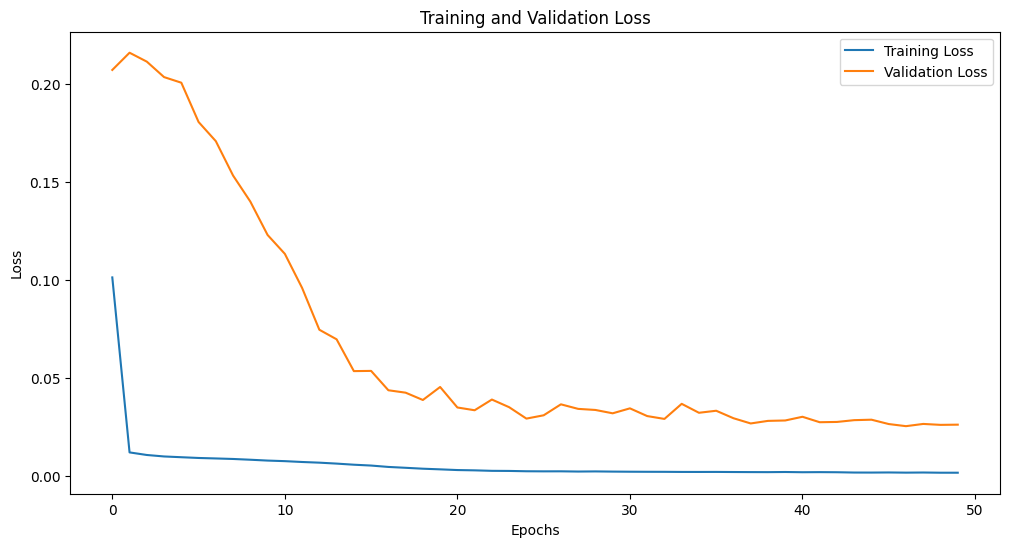

In [396]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Plot Training and Validation MAE**

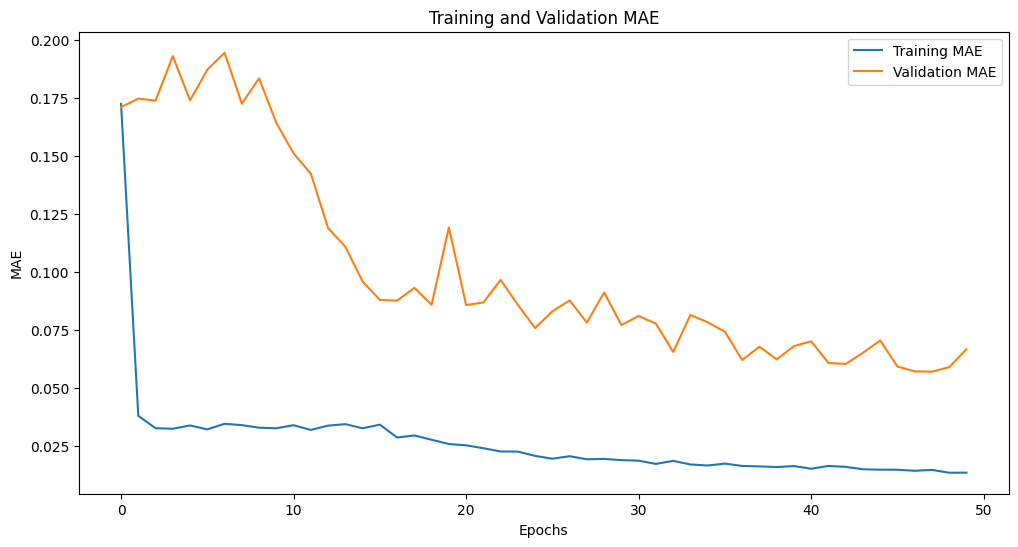

In [397]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()